In [1]:
#Labraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Import for dataset:
df = pd.read_excel("Online Retail.xlsx")
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
#dataset Overview:
print("check for information\n:",df.info())
print("Check for statistics summary\n:",df.describe())
print("check for missing value:\n",df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
check for information
: None
Check for statistics summary
:             Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-1

In [9]:
#Data Cleaning:
df.dropna(subset=["CustomerID"],inplace=True)
df=df[(df['Quantity']>0) & (df['UnitPrice']>0)]
df=df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

In [12]:
#Create RFM:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# ✅ RFM calculation
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

# ✅ Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40
...,...,...,...
18280.0,278,1,180.60
18281.0,181,1,80.82
18282.0,8,2,178.05


In [14]:
#RFM Scoring:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

#Combined Score:
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].sum(axis=1).astype(int)


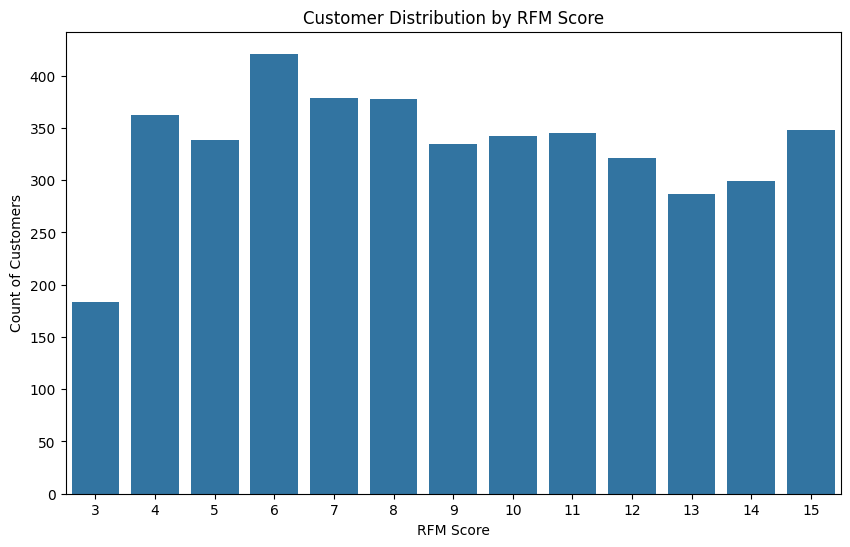

In [15]:
#Bonus:Visulization:
plt.figure(figsize=(10,6))
sns.countplot(x='RFM_Score', data=rfm)
plt.title('Customer Distribution by RFM Score')
plt.xlabel('RFM Score')
plt.ylabel('Count of Customers')
plt.show()


In [17]:
def segment_customer(score):
    if score >= 12:
        return 'Top Customers'
    elif score >= 9:
        return 'Loyal'
    elif score >= 6:
        return 'Potential'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)
rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,7,Potential
12347.0,2,7,4310.00,5,5,5,555,15,Top Customers
12348.0,75,4,1797.24,2,4,4,244,10,Loyal
12349.0,19,1,1757.55,4,1,4,414,9,Loyal
12350.0,310,1,334.40,1,1,2,112,4,At Risk
